In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json
import pickle

# Load Model and Predict Methods

In [2]:
from sklearn.preprocessing import StandardScaler
import re

class CustomScaler1():
    standard_scaler = None
    fit = False
    stdcols = ['number_of_trades','volume','quote_asset_volume',
               'taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
              ]
    tostd = []
    atr_max = 0
    atr_diff_std = 0
    rsi_diff_std = 0
    
    min_max_range=(-1, 1)
    
    def __init__(self):
        self.standard_scaler = StandardScaler()
        
    def fit(self, X):
        for c in self.stdcols:
            for v in X.columns:
                if v.startswith(c):
                    self.tostd.append(v)
                
        if len(self.tostd) > 0:
            self.standard_scaler.fit(X[self.tostd])
            
        if 'atr' in X.columns:
            self.atr_max = X['atr'].max()
        if 'atr_diff' in X.columns:
            self.atr_diff_std = X['atr_diff'].std()
        if 'rsi_diff' in X.columns:
            self.rsi_diff_std = X['rsi_diff'].std()
            
        self.fit = True
        return self
        
    def transform(self, X_in):
        if self.fit == True:
            X = X_in.copy()
            open_price = X['open'].copy()
            stddev = (((X['close'] - X['open'])**2 + \
                       (X['high'] - X['open'])**2 + \
                       (X['low'] - X['open'])**2) / 3)**0.5
            stddev = stddev.apply(lambda x: 1 if x==0 else x)
            
            for c in X.columns:
                if c in ['open','high','low','close'] or \
                   re.match('open_[0-9]+', c) or \
                   re.match('high_[0-9]+', c) or \
                   re.match('low_[0-9]+', c) or \
                   re.match('close_[0-9]+', c) or \
                   re.match('sup[0-9]+', c) or \
                   re.match('res[0-9]+', c) or \
                   re.match('ma[0-9]+', c):
                    X[c] = (X[c]-open_price)/stddev
                elif c.startswith('atr_diff') and self.atr_diff_std>0:
                    X[c] = X[c]/self.atr_diff_std
                elif re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',c):
                    X[c] = X[c]/self.atr_max
                elif c.startswith('rsi_diff') and self.rsi_diff_std>0:
                    X[c] = X[c]/self.rsi_diff_std
                elif re.match('rsi$|rsi_[0-9]+|rsi_ma[0-9]+',c):
                    X[c] = (X[c]-50)/20 # thus the 30/70 thresholds will become -1/1
            
            if 'dow' in X.columns:
                X['dow'] = X['dow'] / 6
                
            if len(self.tostd) > 0:
                X[self.tostd] = self.standard_scaler.transform(X[self.tostd])
            return X
        else:
            raise Exception('ModelScaler not yet fit')
            
    def fit_transform(self, X_in):
        self.fit(X_in)
        return self.transform(X_in)

class CustomScaler2():
    stdcols = ('number_of_trades','volume','quote_asset_volume',
               'taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
               )
    
    def __init__(self):
        self.standard_scaler = StandardScaler()
        self.tostd = []
        self.is_fit = False
        
    def fit(self, X):
        for c in self.stdcols:
            for v in X.columns:
                if v.startswith(c):
                    self.tostd.append(v)
                
        if len(self.tostd) > 0:
            self.standard_scaler.fit(X[self.tostd])
            
        self.is_fit = True
        return self
        
    def transform(self, X_in):
        if self.is_fit == True:
            X = X_in.copy()
            open_price = X['open'].copy()
            stddev = (((X['close'] - X['open'])**2 + \
                       (X['high'] - X['open'])**2 + \
                       (X['low'] - X['open'])**2) / 3)**0.5
            stddev = stddev.apply(lambda x: 1 if x==0 else x)
            
            rsi_values = X['rsi'].copy()
            atr_values = X['atr'].copy()
            atr_values = atr_values.apply(lambda x: 1 if x==0 else x)
            
            for c in X.columns:
                if c in ['open','high','low','close'] or \
                   re.match('open_[0-9]+', c) or \
                   re.match('high_[0-9]+', c) or \
                   re.match('low_[0-9]+', c) or \
                   re.match('close_[0-9]+', c) or \
                   re.match('sup[0-9]+', c) or \
                   re.match('res[0-9]+', c) or \
                   re.match('ma[0-9]+', c):
                    X[c] = (X[c]-open_price)/stddev
                elif c.startswith('atr_diff'):
                    X[c] = X[c]/atr_values
                elif re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',c):
                    X[c] = X[c]-atr_values/atr_values
                elif c.startswith('rsi_diff'):
                    X[c] = X[c]/rsi_values
                elif re.match('rsi$|rsi_[0-9]+|rsi_ma[0-9]+',c):
                    X[c] = (X[c]-50)/20 # thus the 30/70 thresholds will become -1/1
            
            if 'dow' in X.columns:
                X['dow'] = X['dow'] / 6
                
            if len(self.tostd) > 0:
                X[self.tostd] = self.standard_scaler.transform(X[self.tostd])
            return X
        else:
            raise Exception('CustomScaler not yet fit')
            
    def fit_transform(self, X_in, y=None):
        self.fit(X_in)
        y=self.transform(X_in)
        return y

In [3]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    checkpoint = torch.load(f)
    net = checkpoint['net']
    scaler = checkpoint.get('scaler', None)
    mean_losses = checkpoint['mean_losses']
    return net, scaler, mean_losses

def predict(model, X, y, device='cpu', silent=False):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches, disable=silent):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = torch.round(torch.sigmoid(model(inputs)))
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        if type(X) == np.ndarray:
            X_tensor = torch.from_numpy(X).float()
        else:
            X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = torch.round(torch.sigmoid(model(X_tensor))).detach().numpy()

    return nn_results

# Simulator

In [4]:
def get_target_stoploss(df, threshold_ratio=(0.04,0.02), use_atr=True, atr_ratio=(2,1), reverse=False):
    if not reverse:
        if use_atr:
            stop_losses = df.low-(df.atr*atr_ratio[1])
            targets = df.close+(df.atr*atr_ratio[0])
        else:
            stop_losses = df.close-df.close*threshold_ratio[1]
            targets = df.close+df.close*threshold_ratio[0]
    else:
        if use_atr:
            stop_losses = df.high+(df.atr*atr_ratio[1])
            targets = df.close-(df.atr*atr_ratio[0])
        else:
            stop_losses = df.close+df.close*threshold_ratio[1]
            targets = df.close-df.close*threshold_ratio[0]

    return targets, stop_losses

def get_decisions_and_prices(x_data, pred, info_dict):
    next_action = 1
    target = -1
    stoploss = -1
    
    if type(x_data.index) != pd.RangeIndex:
        x_data = x_data.reset_index(drop=True)
    
    if type(pred) in (pd.DataFrame, pd.Series):
        pred = pred.to_numpy().ravel()

    use_atr = info_dict['model_use_atr']
    atr_ratio = info_dict['model_ratio']
    threshold_ratio = info_dict['model_ratio']
    reverse = info_dict['model_reverse']
        
    targets, stop_losses = get_target_stoploss(x_data,
                                               use_atr=use_atr,
                                               atr_ratio=atr_ratio,
                                               threshold_ratio=threshold_ratio,
                                               reverse=reverse)
    low_prices = x_data['low'].to_numpy()
    high_prices = x_data['high'].to_numpy()
    
    # Decisions:
    # 1 = buy
    # 0 = hold (default)
    # -1 = sell
    decision = pd.Series(0, index=x_data.index)
    execution_price = pd.Series(0.0, index=x_data.index)

    i = 0
    while True:
        if i>=len(x_data):
            break
        if next_action == 1:
            # Find next buy opportunity
            try:
                next_buy_idx = np.where(pred[i:]==1)[0][0] + i
                target = targets.iloc[next_buy_idx]
                stoploss = stop_losses.iloc[next_buy_idx]
                decision.at[next_buy_idx] = 1
                execution_price.at[next_buy_idx] = x_data.loc[next_buy_idx, 'close']
                i = next_buy_idx+1
                next_action = -1
            except:
                # No more buy opportunties
                break
        else:
            # Find next sell opportunity
            try:
                if not reverse:
                    next_sell_idx = np.where((high_prices[i:]>=target) | (low_prices[i:]<=stoploss))[0][0] + i
                else:
                    next_sell_idx = np.where((low_prices[i:]<=target) | (high_prices[i:]>=stoploss))[0][0] + i
                if x_data.loc[next_sell_idx, 'low'] <= target <= x_data.loc[next_sell_idx, 'high']:
                    execution_price.at[next_sell_idx] = target
                else:
                    execution_price.at[next_sell_idx] = stoploss
                decision.at[next_sell_idx] = -1
                i = next_sell_idx+1
                next_action = 1
            except:
                # No more sell opportunties
                break

    return decision, execution_price

def simulate(in_df, starting_value, trading_fees_percent, trading_fees_buy, trading_fees_sell):
    df = in_df.copy()
    df['value'] = 0.0
    value = starting_value
    fee_multiplier = 1.0 - trading_fees_percent / 100

    for x,r in df.iterrows():
        if r.decision == 1 and value > 0:
            value = ((value-trading_fees_buy) * r.price) * fee_multiplier
            if value < 0:
                break
        elif r.decision == -1 and value > 0:
            value = ((value-trading_fees_sell) / r.price) * fee_multiplier
            if value < 0:
                break
        else:
            break # value is below zero
        df.loc[x,'value'] = value
    return df.value

def run_simulator(X, y, model_use_atr, model_ratio, model_reverse,
                  starting_value=1, trading_fees_percent=0.1,
                  trading_fees_buy=0, trading_fees_sell=0):
    df = X.copy()
    d = dict(model_use_atr=model_use_atr, model_ratio=model_ratio, model_reverse=model_reverse)
    
    decision, execution_price = get_decisions_and_prices(X, y, d)
    
    df['decision'] = decision.values
    df['price'] = execution_price.values
    
    sim_df = df[df['decision']!=0][['decision','price']].copy()
    if len(sim_df) == 0:
        return starting_value
    else:
        sim_df['value'] = simulate(sim_df, starting_value, trading_fees_percent, trading_fees_buy, trading_fees_sell)
        return sim_df[sim_df.decision==-1].value.to_numpy()[-1]

# Limit Features

In [5]:
import re

# Drop columns with lookbacks equal to or greater than X
def get_columns(x=14):
    columns = list(X_train.columns)
    for c in X_train.columns:
        if m := re.match(r'^.*_([0-9]+)$', c):
            if int(m[1]) > x:
                columns.remove(c)
    return columns

# Analyze Results

In [6]:
def train_test_split(X, y, train_idx=None, test_idx=None):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    return (X_train, y_train, X_test, y_test)

def load_split_data(suffix, split=False):
    X = pd.read_pickle(f'../data/X_{suffix}.pkl')
    y = pd.read_pickle(f'../data/y_{suffix}.pkl')
    if split:
        X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc['2018':'2020'].index, X.loc['2021':].index)
        return X_train, y_train, X_test, y_test
    else:
        return X, y
    
X_train, y_train, X_test, y_test = load_split_data(suffix='20210806i', split=True)

  0%|          | 0/22 [00:00<?, ?it/s]

alpha8 Profit 0.1484 Prec 0.4317 Recall 0.1799
alpha9 Profit 0.062 Prec 0.4122 Recall 0.5837
alpha10 Profit 0.047 Prec 0.4056 Recall 0.5838
alpha11 Profit 0.0234 Prec 0.4097 Recall 1.0
alpha12 Profit 1 Prec 0.0 Recall 0.0
alpha13 Profit 0.0321 Prec 0.412 Recall 0.9226
alpha14 Profit 0.0604 Prec 0.4081 Recall 0.4803
alpha15 Profit 0.1023 Prec 0.4204 Recall 0.2973
alpha16 Profit 0.0305 Prec 0.4146 Recall 0.8329
alpha17 Profit 0.0377 Prec 0.4081 Recall 0.771
alpha18 Profit 0.0479 Prec 0.4133 Recall 0.7561
alpha19 Profit 0.0448 Prec 0.4129 Recall 0.5695
alpha20 Profit 0.2091 Prec 0.442 Recall 0.2342
alpha21 Profit 0.3994 Prec 0.4421 Recall 0.0726
alpha22 Profit 1 Prec 0.0 Recall 0.0
alpha23 Profit 1.0037 Prec 1.0 Recall 0.0001
alpha24 Profit 0.6418 Prec 0.5034 Recall 0.1361
alpha25 Profit 0.887 Prec 0.5199 Recall 0.043
alpha26 Profit 1 Prec 0.0 Recall 0.0
alpha27 Profit 1 Prec 0.0 Recall 0.0
alpha28 Profit 0.6767 Prec 0.5087 Recall 0.0717
alpha29 Profit 0.0899 Prec 0.4158 Recall 0.3895


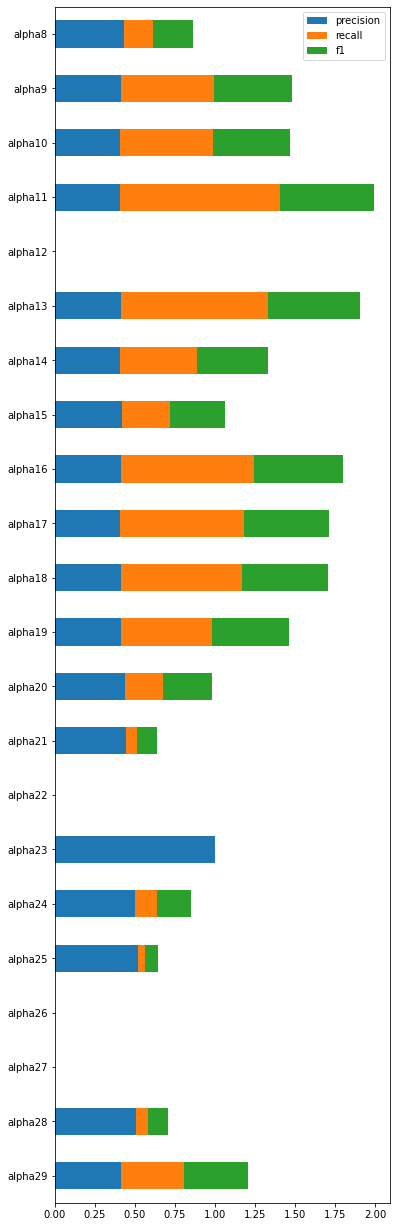

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm.notebook import tqdm

model_ids=[ #'alpha1', - columns??
            #'alpha2', - columns??
            #'alpha3', - columns??
            #'alpha4',  # Data = 20210726 - columns??
            #'alpha5',  # Data = 20210726 - columns??
            #'alpha6',  # Data = 20210726 - columns??
            #'alpha7',  # Data = 20210729a - columns??
            'alpha8',  # Data = 20210801f
            'alpha9',  # Data = 20210801f
            'alpha10',  # Data = 20210801f - 
            'alpha11',  # Data = 20210801f - CustomScaler1
            'alpha12',  # Data = 20210801f - CustomScaler1
            'alpha13',  # Data = 20210801f - NNModelEx
            'alpha14',
            'alpha15',
            'alpha16',
            'alpha17',
            'alpha18',
            'alpha19',
            'alpha20',  # Data = 20210806i - CustomScaler2
            'alpha21',
            'alpha22',
            'alpha23',
            'alpha24',
            'alpha25',
            'alpha26',
            'alpha27',
            'alpha28',
            'alpha29',
          ]


def get_metrics(model_id, X_test, y_test):
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    model, scaler, _ = load_model_only(config)
    
    lookbacks = config.get('lookbacks',14)
    columns = get_columns(lookbacks)
    
    if scaler is not None:
        try:
            X = scaler.transform(X_test[columns].copy())
        except Exception as e:
            print('Failed on ', model_id, 'Columns:', columns, 'Config', config)
            raise e
    else:
        X = X_test[columns]
    
    predictions = predict(model, X, y_test, device=config['device'], silent=True)
    predictions = np.nan_to_num(predictions)
    
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1score = f1_score(y_test, predictions, zero_division=0)
    profit = run_simulator(X_test, predictions, model_use_atr=True, model_ratio=(2,1), model_reverse=True)
    return precision, recall, f1score, predictions, profit

precision = {}
recall = {}
f1score = {}
profit = {}

for model_id in tqdm(model_ids):
    p, r, f, _, pf = get_metrics(model_id, X_test, y_test)
    
    precision[model_id] = round(p,4)
    recall[model_id] = round(r,4)
    f1score[model_id] = round(f,4)
    profit[model_id] = round(pf,4)
    print(model_id, 'Profit', profit[model_id], 'Prec', precision[model_id],'Recall', recall[model_id])

metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
torch.cuda.empty_cache()
plt.gca().invert_yaxis()
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

nm_torch1_alpha30 Profit 0.0761 Prec 0.4143 Recall 0.3377
nm_torch1_alpha31 Profit 0.6457 Prec 0.5194 Recall 0.1027
nm_torch1_alpha32 Profit 0.9454 Prec 0.5805 Recall 0.0167
nm_torch1_alpha33 Profit 0.3472 Prec 0.4821 Recall 0.2344
nm_torch1_alpha34 Profit 1 Prec 0.0 Recall 0.0
nm_torch1_alpha35 Profit 1.0391 Prec 0.4118 Recall 0.0026
nm_torch1_alpha36 Profit 1 Prec 0.0 Recall 0.0
nm_torch1_alpha37 Profit 0.424 Prec 0.4723 Recall 0.1775


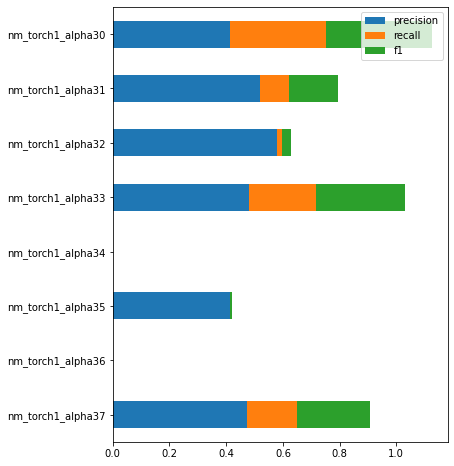

In [15]:
model_ids=[
            'nm_torch1_alpha30',
            'nm_torch1_alpha31',
            'nm_torch1_alpha32',
            'nm_torch1_alpha33',
            'nm_torch1_alpha34',
            'nm_torch1_alpha35',
            'nm_torch1_alpha36',
            'nm_torch1_alpha37',
]
precision = {}
recall = {}
f1score = {}
profit = {}

for model_id in tqdm(model_ids):
    p, r, f, _, pf = get_metrics(model_id, X_test, y_test)
    
    precision[model_id] = round(p,4)
    recall[model_id] = round(r,4)
    f1score[model_id] = round(f,4)
    profit[model_id] = round(pf,4)
    print(model_id, 'Profit', profit[model_id], 'Prec', precision[model_id],'Recall', recall[model_id])

metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
torch.cuda.empty_cache()
plt.gca().invert_yaxis()
plt.show()